In [8]:
# importing libraries
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image
import cv2
import time
import os
from deepface import DeepFace
import matplotlib.pyplot as plt
import math
from mtcnn import MTCNN
from retinaface import RetinaFace
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
# from imutils.video import VideoStream
# import imutils


In [9]:
#MODELS-DETECTORS-METRICS
models = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace"]
backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface', 'mediapipe']
metrics = ["cosine", "euclidean", "euclidean_l2"]

usedModel=models[2]
usedBackend=backends[3]
usedMetric=metrics[2]

jawUsed='jaw2.png'


In [10]:
#putting the jaw on the unmaked image and saving it as face1 file
#to read the image, detect the face part and resize accordingly:
def func1(imgpath):
    img=cv2.imread(imgpath)
#     img=cv2.resize(img, (100, 100))
    #height, width, channels = img.shape 
    detected_face = DeepFace.detectFace( img, detector_backend = usedBackend,enforce_detection=False)
    img=detected_face
    img=cv2.resize(img, (100, 100)) 
    plt.imsave('forocv.png',img)
    img=cv2.imread("forocv.png")

    #code to detect coordinates of eyes, nose, mouth etc:
    #coordinates=RetinaFace.detect_faces(imgpath)
    nosex=50 #int(coordinates["face_1"]["landmarks"]["nose"][1]/height*100)

    #to read and resize the constant jaw:
    attachment=cv2.imread(jawUsed)
    attachment=cv2.resize(attachment, (100,100-(nosex)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    attachment = cv2.cvtColor(attachment, cv2.COLOR_BGR2RGB)
#     for i in range(0,nosex):
#         for j in range(0,12):
#             img[i][j]=0
#             attachment[i][j]=0
#             img[i][99-j]=0
#             attachment[i][99-j]=0
            
    #to impose the jaw on the image appropriately below nose according to x-axis:
    img[nosex:]=attachment

    #to impose the jaw on the image appropriately below nose according to y-axis:
#     plt.imshow(img)
#     plt.show()
#     plt.imsave(face1, img)
    return img

#confirming whether face detects again
# detected_face = DeepFace.detectFace( face1 ,detector_backend = usedBackend)


In [11]:
#Code to detect mask on the face and enforce
    
def detect_and_predict_mask(frame, faceNet, maskNet):
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),(104.0, 177.0, 123.0))
    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    # print(detections.shape)
    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []
    # loop over the detections
    for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)
def func2(maskedimg):
    # load our serialized face detector model from disk
    prototxtPath = r"face_detector/deploy.prototxt"
    weightsPath = r"face_detector/res10_300x300_ssd_iter_140000.caffemodel"
    faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

    # load the face mask detector model from disk
    maskNet = load_model("mask_detector.model")

    # # initialize the video stream
    # print("[INFO] starting video stream...")
    # vs = VideoStream(src=0).start()

    # loop over the frames from the video stream
    # while True:
    # 	# grab the frame from the threaded video stream and resize it
    # 	# to have a maximum width of 400 pixels
    # 	frame = vs.read()
    # 	frame = imutils.resize(frame, width=400)

    # 	# detect faces in the frame and determine if they are wearing a
    # 	# face mask or not
    # 	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

    # 	# loop over the detected face locations and their corresponding
    # 	# locations
    # 	for (box, pred) in zip(locs, preds):
    # 		# unpack the bounding box and predictions
    # 		(startX, startY, endX, endY) = box
    # 		(mask, withoutMask) = pred

    # 		# determine the class label and color we'll use to draw
    # 		# the bounding box and text
    # 		label = "Mask" if mask > withoutMask else "No Mask"
    # 		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

    # 		# include the probability in the label
    # 		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

    # 		# display the label and bounding box rectangle on the output
    # 		# frame
    # 		cv2.putText(frame, label, (startX, startY - 10),
    # 			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    # 		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    # 	# show the output frame
    # 	cv2.imshow("Frame", frame)
    # 	key = cv2.waitKey(1) & 0xFF

    # 	# if the `q` key was pressed, break from the loop
    # 	if key == ord("q"):
    # 		break

    img = cv2.imread(maskedimg)
    coords,p=detect_and_predict_mask(img, faceNet, maskNet)
    # print(coords)
    x1,y1,x2,y2=coords[0]
    img = img[y1:y2,x1:x2]
    # cv2.imwrite('cropped.png',img)

    # cv2.imshow("cropped", crop_img)
    # do a bit of cleanup
    # cv2.destroyAllWindows()
    # vs.stop()


    #To resize and impose the mask on the face

    img=cv2.resize(img, (85, 100)) 
    nosex=50 #int(coordinates["face_1"]["landmarks"]["nose"][1]/height*100)
    #to read and resize the constant jaw:
    attachment=cv2.imread('jaw2.png')
    attachment=cv2.resize(attachment, (100,100-(nosex)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    attachment = cv2.cvtColor(attachment, cv2.COLOR_BGR2RGB)



    color = [0,0,0] # 'cause purple!
    # border widths; I set them all to 150
    top, bottom, left, right = [0,0,15,15]
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)


    # for i in range(0,nosex):
    #     for j in range(0,12):
    #         img[i][j]=0
    #         attachment[i][j]=0
    #         img[i][99-j]=0
    #         attachment[i][99-j]=0        
    # to impose the jaw on the image appropriately below nose according to x-axis:
    img=cv2.resize(img, (100, 100))
    img[nosex:]=attachment
#     plt.imshow(img)
#     plt.show()
#     plt.imsave(face2, img)
    return img
    # detected_face = DeepFace.detectFace( face2 ,detector_backend = usedBackend)
    # print("valid  face confirmed")

In [19]:
x='antony.jpg' #path of the unmasked image

y='antonymask.jpg'   #path of the masked image
try:
    result=DeepFace.verify(func1(x), func2(y), model_name=usedModel, detector_backend = usedBackend, distance_metric = usedMetric )
except:
    result=DeepFace.verify(func1(x), func1(y), model_name=usedModel, detector_backend = usedBackend, distance_metric = usedMetric )
    
print("Is the  face same?: " + 'True') if result['distance'] < 0.8 else print("Is the  face same?: " + 'False')
for i in result:
    print(str(i)+": "+str(result[i])) if(i!='verified' or i!='threshold') else print('')

1/1 [==============================] - 0s 47ms/step
Is the  face same?: True
verified: True
distance: 0.4739723698388897
threshold: 1.04
model: Facenet512
detector_backend: mtcnn
similarity_metric: euclidean_l2


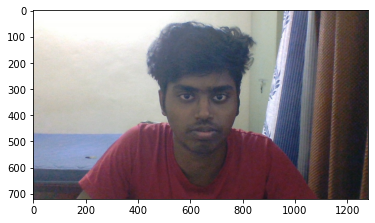

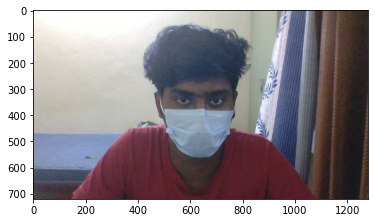

In [20]:
plt.imshow(cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(cv2.imread(y), cv2.COLOR_BGR2RGB))
plt.show()

1/1 [==============================] - 0s 20ms/step


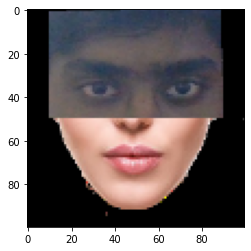

mtcnn
1/1 [==============================] - 0s 17ms/step


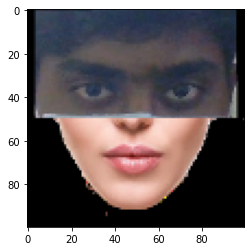

In [21]:
plt.imshow(func1(x))
plt.show()
try:
    plt.imshow(func2(y))
    plt.show()
except:
    print('mtcnn')
    plt.imshow(func1(y))
    plt.show()
    